# Project 1, Part 2, Executive Questions: Customer Specific Questions

University of California, Berkeley
Master of Information and Data Science (MIDS) program
w205 - Fundamentals of Data Engineering

Student: PRAKASH KRISHNAN

Year: 2021-2022

Semester: SPRING 2022

Section: WBL 011


# Included Modules and Packages

Code cell containing your includes for modules and packages

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import psycopg2

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [2]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

# Connect to the Postgres database¶
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

# Create a cursor for the connection
cursor = connection.cursor()


# Format float displays in a dataframe
pd.options.display.float_format = '{:,.3f}'.format

# Instructions for Specific Questions

For each specific quesion, you must write 1 and only 1 query that answers that specific question.  The results of your query must be displayed in a Pandas dataframe as demonstrated in the labs

All output should be sorted.

For store name, use the city name the store is located in.

When sorting by store name, sort in alphabetical order.


# View to join stores to sales; also creates several useful derived columns¶

# 1.2.1 Total Number of Customers for all of AGM

In [3]:
# Total number of customers is a table level summary customers table. 

rollback_before_flag = True
rollback_after_flag = True

query = """

select count(*) from
customers

"""
my_select_query_pandas(query, rollback_before_flag, rollback_after_flag).iloc[0,0]

31082

# 1.2.2 Total Number of Customers by Store

Sort by store name in alphabetical order

In [4]:
# Join of Stores Table and Customers Table

# In the Query store.store_id and store.city were used as it was conceivable that you could have more than one store
# in a city. So to get a unique store view, both store_id and city were used.

rollback_before_flag = True
rollback_after_flag = True

query = """

select s.store_id, s.city as store, count(first_name) as customer_count from customers as cu
join stores as s
  on s.store_id = cu.closest_store_id
group by s.store_id, s.city
order by s.city

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag).loc[:,['store','customer_count']]

,store,customer_count
0,Berkeley,8138
1,Dallas,6359
2,Miami,5725
3,Nashville,3646
4,Seattle,7214


# 1.2.3 Total Number of Customers by Distance from Store

Sort by shortest distance first

In [5]:
# Join customers table and stores table

rollback_before_flag = True
rollback_after_flag = True

query = """

select cu.distance as distance_from_closest_store, count(first_name) as customer_count from customers as cu
join stores as s
  on s.store_id = cu.closest_store_id
group by cu.distance
order by cu.distance asc

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,distance_from_closest_store,customer_count
0,1,2790
1,2,1685
2,3,2417
3,4,2994
4,5,2426
5,6,2478
6,7,2107
7,8,2311
8,9,1906
9,10,1779


# 1.2.4 List of Customers who have signed up but not bought anything

Sort by customer last name, then first name

In [6]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select cu.last_name, cu.first_name, cu.customer_id
from customers as cu
left join sales as s
on s.customer_id = cu.customer_id
where s.customer_id is null
order by cu.last_name, cu.first_name

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag).loc[:,['last_name','first_name']]

,last_name,first_name
0,Agott,Tracy
1,Arnke,Daniella
2,Assandri,Hyacintha
3,Borman,Felice
4,Breit,Domini
5,Butterick,Jacenta
6,Camillo,Marysa
7,Dukelow,Lilas
8,Dukesbury,Corinna
9,Ellaway,Lorianna


# 1.2.5 What is the percentage of customers per population at the zip code level?

Sort by highest percentage first

In [7]:
# A join of customers and zip_codes tables

rollback_before_flag = True
rollback_after_flag = True

query = """

select zip_codes.zip, (count(customers.customer_id)/zip_codes.population)*100 as per_cent from zip_codes
join customers
on customers.zip = zip_codes.zip
group by zip_codes.zip
order by per_cent desc


"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,zip,per_cent
0,98164,1.290
1,98050,1.087
2,33109,1.053
3,94613,1.045
4,37240,1.028
...,...,...
545,33033,0.002
546,75067,0.001
547,75035,0.001
548,94565,0.001


# 1.2.6 What is the percentage of customers per population at the city level?

Sort by highest percentage first

In [8]:
# In reviewing the data, there were many cities with same name in different states. So a group by just city does not make
# sense and a composite grouping of city and state was used.

rollback_before_flag = True
rollback_after_flag = True

query = """

select cities.state, cities.city, (count(customers.customer_id)/cities.population)*100 as per_cent from cities
join customers
on customers.city = cities.city and customers.state = cities.state
group by cities.state, cities.city
order by per_cent desc, cities.city, cities.state

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,state,city,per_cent
0,WA,Preston,1.087
1,WA,Indianola,1.027
2,CA,Stinson Beach,1.016
3,WA,Medina,1.012
4,WA,Suquamish,1.009
...,...,...,...
193,TN,Murfreesboro,0.002
194,TX,Wylie,0.002
195,CA,Pleasanton,0.001
196,TX,Frisco,0.001


# 1.2.7 The Executives have also asked you to provide your best example of a data visualization for one of the above queries

You may choose any one of the above queries. 

It's best to select the one that you think will provide the most interesting data visualization.  

You are allowed to add a pivot as demonstrated in the labs if it is needed for your data visualization. 

## Data Visualization

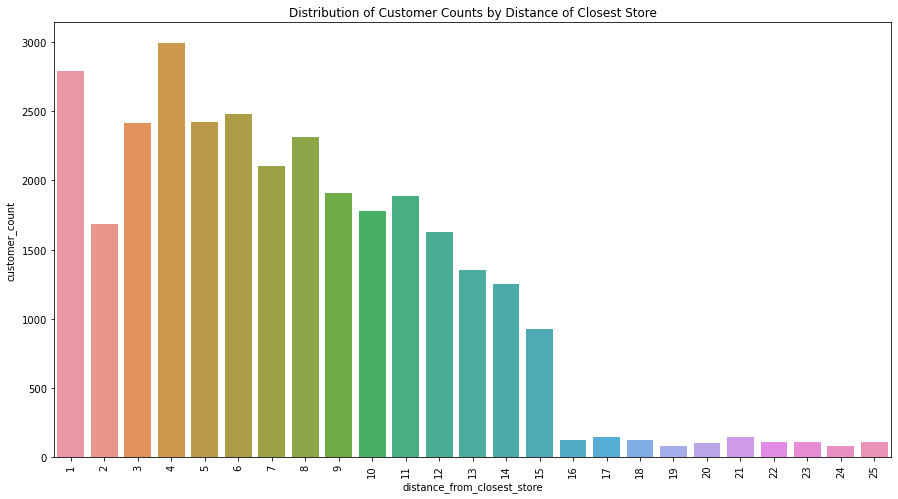

In [9]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select cu.distance as distance_from_closest_store, count(first_name) as customer_count from customers as cu
join stores as s
  on s.store_id = cu.closest_store_id
group by cu.distance
order by cu.distance asc

"""
df=my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

plt.figure(figsize=(15,8))
ax=sns.barplot(x='distance_from_closest_store',y='customer_count',data=df)
plt.xticks(rotation='vertical')
plt.title("Distribution of Customer Counts by Distance of Closest Store")
plt.show()